In [1]:
#meta 4/15/2021 myClassify (multiclass) for LSHTC - Train model with fast.ai
# task: classify text (multiclass) 
# input: preprocessed subset: lshtc3_wikipedia_med_df_train_sub_multilabel_tidy.pkl
#      LSHTC3 reduced ds with less labels

#ref https://towardsdatascience.com/censoring-toxic-comments-using-fastai-v2-with-a-multi-label-text-classifier-12688157d0e6

#task: Multi-category text classification - supervised
#based on 1_classify_sentiment_spacy_multi.ipynb


#history
#      4/15/2021 FAST.AI in AML
#      Accuracy ~61% 
#      4/19/2021 TRY FAST.AI in Kaggle - NAIVE TEXT CLF, ONE LABEL
#      Naive classifier - one label per doc, so docs repeated multiple times
#      Goal: check out if naive text classifier runs ok with 139 labels
#      Accuracy ~62%, improves by 1%

#      4/25/2021 FAST.AI MULTI-LABEL TEXT Clf
#      Multi-label classifier - multiple labels per doc, so no repeated docs
#      Goal: figure out how to input the data for text classifier learner w/ multi-labels
#      Accuracy ~?% 

#note: $config before saving to repo
#note: $error Important reset index - fast.ai dataloaders don't like a gap in index
#      to avoid -> TypeError: 'float' object is not iterable



In [2]:
%matplotlib inline
#import time as time #to track performance time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump

In [3]:
from fastai.text.all import *

In [4]:
#declare vars
SEED = 24

# LSHTC: Classify Text 
Train text classifier using Transfer Learning.  2 steps:  
1. fine-tune our language model pretrained on Wikipedia to the corpus of Expeditors survey  
2. use that model to train a classifier  



## 0. Load Data
input: a prepared pickle with pre-selected relevant fields.

In [5]:
df_tidy = load('../input/mylshtc3train/lshtc3_wikipedia_med_df_train_sub_multilabel_tidy.pkl') 
print(df_tidy.shape)
print(df_tidy.columns)
print(df_tidy.dtypes)
df_tidy.head()


(127043, 2)
Index(['text', 'labels'], dtype='object')
text      object
labels    object
dtype: object


,text,labels
0,"Alain Connes (born 1 April 1947) is a French mathematician, currently Professor at the Coll\u00E8ge de France, IH\u00C9S and Vanderbilt University.",130762
1,"Ayn Rand (born Alisa Zinov'yevna Rosenbaum; February 2 1905 – March 6, 1982), was a Russian-American novelist, philosopher, playwright, and screenwriter. She is known for her two best-selling novels and for developing a philosophical system she called Objectivism. Born and educated in Russia, Rand immigrated to the United States in 1926. She worked as a screenwriter in Hollywood and had a play produced on Broadway in 1935\u20131936. She first achieved fame in 1943 with her novel The Fountainhead, which in 1957 was followed by her best-known work, the philosophical novel Atlas Shrugged. Ran...",352578 395447 27512
2,"Allan Dwan (April 3, 1885 – December 28, 1981) was a pioneering Canadian-born American motion picture director, producer and screenwriter.",390846 395447
3,"Andre Kirk Agassi (born April 29, 1970) is an American former World No. 1 professional tennis player who won eight Grand Slam singles tournaments and an Olympic gold medal in singles. Generally considered by critics and fellow players to be one of the greatest tennis players of all time, he has been called the best service returner in the history of tennis. Known for his unorthodox apparel and attitude, Agassi is often cited as one of the most charismatic players in the history of the game, and is credited for helping revive the popularity of tennis during the 1990s. He is married to fello...",14661
4,"Aldous Leonard Huxley (26 July 1894 \u2013 22 November 1963) was an English writer and one of the most prominent members of the famous Huxley family. He spent the later part of his life in the United States, living in Los Angeles from 1937 until his death in 1963. Best known for his novels including Brave New World and wide-ranging output of essays, Huxley also edited the magazine Oxford Poetry, and published short stories, poetry, travel writing, and film stories and scripts. Aldous Huxley was a humanist and pacifist, and he was latterly interested in spiritual subjects such as parapsycho...",106615


In [6]:
#clean df
df = df_tidy[['text', 'labels']].copy()
###df.columns = ['text', 'label']

#reset index - dataloaders don't like a gap in index
#to fix error in next cell: TypeError: 'float' object is not iterable
#df.reset_index(drop=True, inplace=True)

df.head(2)

,text,labels
0,"Alain Connes (born 1 April 1947) is a French mathematician, currently Professor at the Coll\u00E8ge de France, IH\u00C9S and Vanderbilt University.",130762
1,"Ayn Rand (born Alisa Zinov'yevna Rosenbaum; February 2 1905 – March 6, 1982), was a Russian-American novelist, philosopher, playwright, and screenwriter. She is known for her two best-selling novels and for developing a philosophical system she called Objectivism. Born and educated in Russia, Rand immigrated to the United States in 1926. She worked as a screenwriter in Hollywood and had a play produced on Broadway in 1935\u20131936. She first achieved fame in 1943 with her novel The Fountainhead, which in 1957 was followed by her best-known work, the philosophical novel Atlas Shrugged. Ran...",352578 395447 27512


## 1. Data Prep for fast.ai
Prepare our data for the language model and for the classification model separately, using fast.ai library.

### 1.1 Data Prep for Language Model Using DataBlock
fastai handles tokenization and numericalization automatically when `TextBlock` is passed to `DataBlock`. `DataBlock`'s handy `summary` method is useful for debugging data issues.


Putting Our Texts into Batches for a Language Model

In [14]:
# Tokenize the dataframe to have all the descriptions tokenized properly and build a DataLoaders
# Specify the column that contains the text
# Mention explicitly that this dls is meant for language model
# Specify how much data is within train and validation sets
# optional Pick a sequence length i.e. how many words to feed through the RNN at once 
# optional Specify the batch size for the dataloader

# For creating a language model
#src https://docs.fast.ai/text.data.html#TextDataLoaders.from_df
dls_lm = TextDataLoaders.from_df(df, text_col='text', is_lm=True, valid_pct = 0.15, splitter=RandomSplitter(valid_pct = 0.15, seed = SEED)) #$delta valid_col='is_valid' 
dls_lm.show_batch(max_n=3)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj hari xxmaj xxunk ( born 1982 ) is a stand - up comic and actor of xxmaj south xxmaj indian heritage . a graduate of xxmaj bowdoin xxmaj college , he has appeared on xxmaj jimmy xxmaj kimmel xxmaj live as well as appearing on a variety of national comedy festivals , including the 2007 xxup hbo xxup u.s . xxmaj comedy xxmaj arts xxmaj festival . xxmaj additionally ,","xxmaj hari xxmaj xxunk ( born 1982 ) is a stand - up comic and actor of xxmaj south xxmaj indian heritage . a graduate of xxmaj bowdoin xxmaj college , he has appeared on xxmaj jimmy xxmaj kimmel xxmaj live as well as appearing on a variety of national comedy festivals , including the 2007 xxup hbo xxup u.s . xxmaj comedy xxmaj arts xxmaj festival . xxmaj additionally , he"
1,"xxmaj myles xxmaj wilder . xxmaj it was one of several films made in the early 1950s by the xxmaj wilder brothers , xxmaj xxunk , and most of the same crew , independently on a financing - for - distribution basis with xxmaj united xxmaj artists and , occasionally , rko - radio xxmaj pictures . xxbos xxmaj robert xxup i. xxup h. xxmaj xxunk ( july 17 , 1928 \","myles xxmaj wilder . xxmaj it was one of several films made in the early 1950s by the xxmaj wilder brothers , xxmaj xxunk , and most of the same crew , independently on a financing - for - distribution basis with xxmaj united xxmaj artists and , occasionally , rko - radio xxmaj pictures . xxbos xxmaj robert xxup i. xxup h. xxmaj xxunk ( july 17 , 1928 \ u2014"
2,"xxmaj jewish people . xxmaj she currently serves on the boards of numerous educational institutions and charitable organizations , many of which focus on xxmaj jewish education , feminism , and raising awareness about the xxmaj holocaust . xxmaj she lives in xxmaj new xxmaj york xxmaj city and has three children , eight grandchildren , and seven great - grandchildren . xxbos xxmaj pine xxmaj mountain xxmaj lake ( xxunk )","jewish people . xxmaj she currently serves on the boards of numerous educational institutions and charitable organizations , many of which focus on xxmaj jewish education , feminism , and raising awareness about the xxmaj holocaust . xxmaj she lives in xxmaj new xxmaj york xxmaj city and has three children , eight grandchildren , and seven great - grandchildren . xxbos xxmaj pine xxmaj mountain xxmaj lake ( xxunk ) is"


In [15]:
#dataset dims
len(dls_lm.train_ds), len(dls_lm.valid_ds)

(107987, 19056)

In [16]:
#view vocab, class list
print("LM vocab size: ", len(dls_lm.vocab))
dls_lm.vocab[5:50]

LM vocab size:  60008


['xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 ',',
 'the',
 '.',
 'in',
 'and',
 'of',
 'a',
 'was',
 'he',
 'is',
 'to',
 '-',
 ')',
 '(',
 'for',
 '"',
 'his',
 'as',
 'on',
 'an',
 'at',
 'by',
 'with',
 "'s",
 'american',
 'from',
 '\\',
 'born',
 'she',
 'new',
 'film',
 'it',
 'also',
 'has',
 'her',
 '3',
 'that',
 'who',
 'first',
 'york',
 'united']

In [35]:
#mystop #$config

Data is ready, we can fine-tune the pretrained language model.

## 2. Model
The LM was pretrained on Wikipedia.  Fine-tune this LM to Expeditors survey corpus, and then use that as the base for our classifier.  
![ULMFiT Process](my-images/ch10_ULMFIT_process.png)
### 2.1 Fine-Tuning the Language Model


In [18]:
# Create & fine tune the language model
# Architecture to use
# Dropout percentage for regularization
# Metrics to understand the performance

#class fastai.text.learner.LMLearner
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16() # to ease GPUs, save the weights of model with 16-point floating precision instead of the regular 32

In [ ]:
#select the appropriate lr
#learn.lr_find()
lr1, lr2 = learn.lr_find()
print(round(lr1, 6), round(lr2, 6))

In [ ]:
#$config lr
learn.fit_one_cycle(1, 1e-2)

In [ ]:
#save and load models
learn.save('1epoch')
#learn = learn.load('1epoch')

Once the initial training has completed, continue fine-tuning the model after unfreezing

In [ ]:
# Unfreeze the model and train the learner agaoin for n more epochs learn.unfreeze()
#$config lr
learn.fit_one_cycle(5, 4e-3) 

In [19]:
# Save the encoder, it'll be used in training the clf portion
#learn.save_encoder('finetuned')

#$config
#learn = learn.load_encoder('finetuned')
learn = learn.load_encoder('/kaggle/input/mylshtc3temp/finetuned')

In [26]:
#$errors out AttributeError: 'tuple' object has no attribute 'shape'
#learn.summary() #class fastai.text.learner.LMLearner

fastai.text.learner.LMLearner

##### Text generation

In [21]:
TEXT = "Baltimore is a nice place to visit because "
N_WORDS = 40
N_SENTENCES = 2
#to predict, must be of class fastai.text.learner.LMLearner
preds = [learn.predict(TEXT, N_WORDS, temperature=0.85) for _ in range(N_SENTENCES)]

In [22]:
print("\n".join(preds))

Baltimore is a nice place to visit because every summer Bon Jovi goes to sea to relax with them . If you guess it came up to me … i remember geography ! " landing your alma mater , and you wo n't go my
Baltimore is a nice place to visit because it 's like that . " you need to celebrate your arrival ! " Prior to his arrival there were common guests clarke in their rooms , daily meals at room sandwich and breakfast and pizza dishes like breakfast


This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### 1.2 Data Prep for Classifier Model Using DataBlock
Creating the Classifier DataLoaders

In [23]:
#define DataBlock
dblock = DataBlock(blocks = (TextBlock.from_df('text', vocab = dls_lm.vocab), MultiCategoryBlock),
                   get_x = ColReader('text'),
                   get_y = ColReader('labels', label_delim = ' '),
                   splitter=RandomSplitter(0.25, seed = SEED),
                   )
dblock.summary(source=df)

Setting-up type transforms pipelines
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Alain Connes (born 1 April 1947) is a French mathematician, currently Professor at the Coll\u00E8ge de France, IH\u00C9S and Vanderbilt University.   
1       Ayn Rand (born Alisa Zinov'yevna Rosenbaum; February 2 1905 – March 6, 1982), was a Russian-American novelist, philosopher, playwright, and screenwriter. She is known for her two best-selling novels and for developing a philosophical system she called Objectivism. Born and educated in Russia, Rand immigrated to the United States in 1926. She 

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Setting up Pipeline: ColReader -- {'cols': 'labels', 'pref': '', 'suff': '', 'label_delim': ' '} -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: ColReader -- {'cols': 'text', 'pref': '', 'suff': '', 'label_delim': None} -> Tokenizer -> Numericalize
    starting from
      labels                                                                                                                                                                                                                                                                                                                        332072
text           [xxbos, xxmaj, hunt, 's, xxmaj, hill, is, a, former, settlement, in, xxmaj, nevada, xxmaj, county, ,, xxmaj, california, ,, xxmaj, united, xxmaj, states, ., xxmaj, hunt, 's, xxmaj, hill, was, located, on, the, xxmaj, sierra, xxmaj, nevada, range, 3.2, miles, (, 5, km, ), north, of, xxmaj, you, xxmaj, 

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Setting up Pipeline: ColReader -- {'cols': 'labels', 'pref': '', 'suff': '', 'label_delim': ' '} -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}
Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: Pad_Chunk -- {'pad_idx': 1, 'pad_first': True, 'seq_len': 72}
Setting up after_batch: Pipeline: 

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (TensorText of size 51, TensorMultiCategory of size 139)
    applying ToTensor gives
      (TensorText of size 51, TensorMultiCategory of size 139)

Adding the next 3 samples

Applying before_batch to the list of samples
  Pipeline: Pad_Chunk -- {'pad_idx': 1, 'pad_first': True, 'seq_len': 72}
    starting from
      [(TensorText of size 51, TensorMultiCategory of size 139), (TensorText of size 183, TensorMultiCategory of size 139), (TensorText of size 139, TensorMultiCategory of size 139), (TensorText of size 142, Ten

In [24]:
# Create a Dataloaders to feed to the model
dls_clf = dblock.dataloaders(df,seq_len=72, bs=64)
dls_clf.show_batch(max_n=3)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,None
0,"xxbos xxmaj richard xxmaj wright xxmaj nowels xxmaj jr . xxmaj rick xxmaj nowels is a xxmaj grammy / xxmaj ivor xxmaj novello award winning songwriter / producer who has worked with many of the most vibrant artists in contemporary music . xxmaj beginning with his number one worldwide hit single , \ xxunk xxmaj is a xxmaj place on xxmaj earth \ u201d by xxmaj belinda xxmaj carlisle in 1987 xxmaj rick has since co - written over 60 top 20 singles . xxmaj his songs have appeared on over 200 million albums . xxmaj he is a multi - instrumentalist ( guitar , keyboards , bass ) who incorporates contemporary sounds and rhythms within classic songwriting . xxmaj rick has written with or had his songs recorded by the following artists : xxmaj madonna , xxmaj dido , xxmaj john xxmaj legend / xxmaj andre 3 xxrep 3",258850;78599
1,"xxbos xxmaj edward xxup s. ( ned ) xxmaj jordan ( november 21 , 1882 \ u2013 xxmaj december 29 , 1958 ) was an xxmaj american entrepreneur , automotive industrialist and pioneer in evocative advertising copy , which he wrote and used to advertise the automobiles produced by his xxmaj jordan xxmaj motor xxmaj car xxmaj company of xxmaj cleveland , xxmaj ohio . xxmaj jordan \ u2019s xxmaj june 1923 advertisement for the company \ u2019s xxmaj somewhere xxmaj west of xxmaj laramie is considered a breakthrough in the art of writing advertising copy . xxmaj jordan was born in xxmaj merrill , xxmaj wisconsin in 1882 , the only son in a family of six children . xxmaj his mother , xxmaj kate xxmaj griffin xxmaj jordan , supported the family by running a series of small general stores along the xxmaj overland xxmaj trail . xxmaj",195321
2,"xxbos xxmaj joseph xxmaj raymond xxmaj desch ( xxunk 3 , 1987 ) was an xxmaj american electrical engineer and inventor . xxmaj during xxmaj world xxmaj war xxup ii , he was xxmaj research xxmaj director of the project to design and manufacture the xxup us xxmaj navy version of the xxunk , a xxunk machine designed to read communications xxunk by the xxmaj german xxmaj enigma . xxmaj desch was born in xxmaj dayton , xxmaj ohio , in 1907 into a family of xxmaj german descent whose livelihood was blacksmithing and wagon - making . xxmaj he attended the xxmaj catholic elementary school of his neighborhood parish , then won a scholarship to the preparatory ( high ) school of the xxmaj university of xxmaj dayton . xxmaj while attending college at xxmaj university of xxmaj dayton , xxmaj desch worked evenings as an inspector at day",297190;59600


In [25]:
len(dls_clf.train_ds), len(dls_clf.valid_ds)

(95283, 31760)

### 2.2 Model Classifier

In [27]:
# Create a classifier learner using the DataLoaders defined above
#class fastai.text.learner.TextLearner
# Specify a model architecture for the learner
# Specify a metric to evaluate performance while training #$config hparam thresh
# Specify the % in dropout layer for regularization

learn = text_classifier_learner(dls_clf, AWD_LSTM, metrics=partial(accuracy_multi, thresh=0.4), drop_mult=0.5).to_fp16() ##$delta metrics=accuracy

Prior to training the classifier, load the encoder from our fine-tuned language model. We use `load_encoder` instead of `load` because we only have pretrained weights available for the encoder; `load` by default raises an exception if an incomplete model is loaded

In [28]:
# Load the embeddings from the finetuned language model in our learner object
#$config
#learn = learn.load_encoder('finetuned')
learn = learn.load_encoder('/kaggle/input/mylshtc3temp/finetuned')

##### Fine-tune classifier
The last step is to train with discriminative learning rates and *gradual unfreezing*. In computer vision we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference

0.158489 0.057544


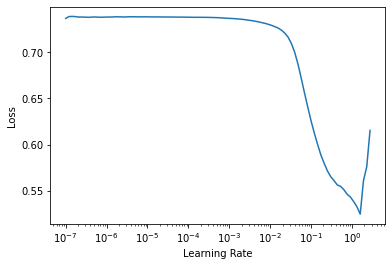

In [29]:
#select the appropriate lr
#$config
#learn.lr_find()
lr1, lr2 = learn.lr_find()
print(round(lr1, 6), round(lr2, 6))

In [30]:
# Fit a small cycle to understand the performance
# $config lr
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.020366,0.017394,0.994479,04:07


In just one epoch we get ? result, compare to our training in <<chapter_intro>>. We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups:

In [31]:
# Unfreeze the last 2 layers and train an epoch while monitoring the performance 
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(0.1/(2.6**4),0.1)) #$delta slice(4e-3/(2.6**4),4e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.017655,0.015156,0.995164,04:34


Unfreeze more and train

In [33]:
# Unfreeze the last 3 layers and train an epoch while monitoring the performance 
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2)) #$delta slice(5e-4/(2.6**4),5e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.015822,0.014066,0.995427,05:59


Finally, the whole model

In [34]:
# Unfreeze all the layers and train 2 epochs while monitoring the performance 
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3)) #$delta slice(1e-4/(2.6**4),1e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.014781,0.014033,0.995475,07:26
1,0.014466,0.013879,0.995488,07:25


We reached 99% accuracy - really need to understand what it means for multi-label LSHTC before celebrating high accuracy. 

Using a pretrained model let us build a fine-tuned language model that was pretty powerful, to either generate fake reviews or help classify them. This is exciting stuff!

In [ ]:
#learn.summary()
#$errors out TypeError: unsupported operand type(s) for +=: 'NoneType' and 'str'
#learn.show_results()

In [ ]:
#save final model
learn.save('clf_final')
# Export the model (.pkl) and save it for inference
learn.export()

## 3. Model Evaluation
src https://docs.fast.ai/interpret.html#ClassificationInterpretation  
src code https://github.com/fastai/fastai/blob/master/fastai/interpret.py#L51
### 3.1 Report and Confusion Matrix

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

       10088       1.00      1.00      1.00   4376658
       10307       0.85      0.58      0.69     37982
      104651       0.00      0.00      0.00         0
       10590       0.00      0.00      0.00         0
      106409       0.00      0.00      0.00         0
      106615       0.00      0.00      0.00         0
      114538       0.00      0.00      0.00         0
      114873       0.00      0.00      0.00         0
      115269       0.00      0.00      0.00         0
      117362       0.00      0.00      0.00         0
      118798       0.00      0.00      0.00         0
      118947       0.00      0.00      0.00         0
      122859       0.00      0.00      0.00         0
      125243       0.00      0.00      0.00         0
      126647       0.00      0.00      0.00         0
      130762       0.00      0.00      0.00         0
       13139       0.00      0.00      0.00         0
      131503       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
plt.rcParams["figure.figsize"] = (10,6)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val = 100)

In [ ]:
interp.plot_top_losses(10)

In [ ]:
interp = TextClassificationInterpretation.from_learner(learn)
x = interp.most_confused()
s = 0
for i in x:
    s += i[2]
print("Total number of wrong classifications:", s)
acc = 1 - 1413/len(valid)
print("Accuracy based on this:", acc)

#### 4. Predict

In [ ]:
learn_inf = load_learner('/kaggle/working/export.pkl')
learn_inf.predic("text goes here"))

In [ ]:
# Predict on the validation dataset
y_pred, y_true =  learn.get_preds()

In [ ]:
accuracy_multi(y_pred, y_true, thresh=0.9, sigmoid=False)

#### Find the best threshold level

In [ ]:
xs = torch.linspace(.05, 0.95, 29)
accs = [accuracy_multi(y_pred, y_true, thresh = i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

In [ ]:
#eval results
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

f1_score(y_true, y_pred>0.35, average='micro')

In [ ]:
y_true = y_true.numpy()
scores = y_pred.numpy()

scores.shape, y_true.shape

In [ ]:
y_true[30]

In [ ]:
dls_clf.valid_ds #__class__ fastai.data.core.Datasets
#dls_clf.valid_ds.cat
len(dls_clf.valid_ds[0][1]) #=139
dls_clf.valid_ds.col_reader #__class__ fastcore.foundation.L
dls_clf.valid_ds.col_reader[1] #__class__ #fastai.data.transforms.ColReader


In [ ]:
metrics = classification_report(y_true, scores>0.35, labels = dls_clf.valid_ds.cat())##$acwas target_names=dls_clf.valid_ds.classes
print(metrics)

In [ ]:
#mystop

## $Xtra. Data Prep for ML


In [36]:
#$xtra Reminder about fast.ai DataBlock
dblock = DataBlock()

dsets = dblock.datasets(df)
len(dsets.train),len(dsets.valid)

x,y = dsets.train[0]
x,y

(text      Mary Lou (born March 15, 1992) is an American actress. She is known for playing Mary Ferry on the Nickelodeon television series Unfabulous.
 labels                                                                                                                                          82093
 Name: 57838, dtype: object,
 text      Mary Lou (born March 15, 1992) is an American actress. She is known for playing Mary Ferry on the Nickelodeon television series Unfabulous.
 labels                                                                                                                                          82093
 Name: 57838, dtype: object)

In [37]:
#$xtra Reminder about fast.ai DataBlock
dblock = DataBlock(get_x = lambda r: r['text'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

("Jill Bakken is an American Olympic bobsledder who has competed since 1994. As driver, she and partner Vonetta Flowers won the gold medal in Bobsleigh at the 2002 Winter Olympics for the U.S. Bakken's best Bobsleigh World Cup season finish was second in the two-woman event in 1999\\u20132000, Bakken is an alumnus of Eastern Washington University, transferring there in 2005. She has also attended the University of Utah and Oregon State University, where she played soccer. Bakken is now a driving coach for the Canadian bobsleigh team and is married to Florian Linder who is also a coach for the Canadian bobsled team. Jill and Florian got married on top of a mountain at Kicking Horse Resort and are the proud owners of Koda, a Samoyed.",
 '157144')

In [38]:
#$xtra Reminder about fast.ai DataBlock
def get_x(r): return r['text']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

("Deer River is a city in Itasca County, Minnesota, United States. The population was 903 at the 2000 census. U.S. Route 2 and Minnesota State Highways 6 and 46 are three of the main routes in the community. Deer River is home to the world's largest Wild Rice Festival. Possibly its greatest attribute is its proximity to several beautiful lakes, including Deer Lake, Bowstring Lake, Leech Lake, and Lake Winnibigoshish.",
 '82220')

In [52]:
#$xtra Reminder about fast.ai DataBlock
def get_x(r): return r['text']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('Bad Company is a 1995 film directed by Damian Harris, (son of the late actor Richard Harris), written by Ross Thomas, and starring Ellen Barkin, Laurence Fishburne and Frank Langella.',
 ['167593'])

In [54]:
#$xtra Reminder about fast.ai DataBlock - more than one label is possible
sets.train[2]

('Scooter Ward (born Ronald Ward Jr. on May 7, 1970) is an American musician. He is the founding member and lead singer of the Jacksonville, Florida hard rock band, Cold, which disbanded on November 17, 2006, and has recently reformed in 2009 for recording a new album which is expected to be released in April 2010.',
 ['443106', '104651'])

In [ ]:
mystop

In [ ]:
print(y.value_counts().sort_index())
y.value_counts().sort_index().plot(kind="bar")

In [ ]:
import fastai
from fastai import *
from fastai.text import *

#from IPython.display import display,HTML 

In [ ]:
#$was
# use TextBlock to create a language model, pass TextBlock to DataBlock
#es_lm = DataBlock(
#    blocks=TextBlock.from_df('text', seq_len=72, is_lm=True),
##    #get_x=ColReader('text'), 
#    splitter=RandomSplitter(0.2, seed = SEED)) 

#dataloaders
#dls_lm = es_lm.dataloaders(df['text'], bs=64)
#dls_lm.show_batch(max_n=2)

In [ ]:
#src https://forums.fast.ai/t/the-interpretation-of-text-classification-throws-an-error-when-used-on-a-pretrained-network/39471
def show_piece_attn(*args, **kwargs):
    from IPython.display import display, HTML
    display(HTML(piece_attn_html(*args, **kwargs)))

def _eval_dropouts(mod):
        module_name =  mod.__class__.__name__
        if 'Dropout' in module_name or 'BatchNorm' in module_name: mod.training = False
        for module in mod.children(): _eval_dropouts(module)
            
class TextClassificationInterpretation(ClassificationInterpretation):
    """Provides an interpretation of classification based on input sensitivity.
    This was designed for AWD-LSTM only for the moment, because Transformer already has its own attentional model.
    """

    def __init__(self, learn: Learner, preds: Tensor, y_true: Tensor, losses: Tensor, ds_type: DatasetType = DatasetType.Valid):
        super(TextClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.model = learn.model

    def intrinsic_attention(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`. """

In [ ]:
#https://github.com/fastai/fastai/pull/2115/files
#from fastai.train import ClassificationInterpretation

#from fastai.data.all import *
from fastai.basic_train import Learner #fastai v1 is not compatible vith v2
from fastai.vision import DatasetType


__all__ = ['TextClassificationInterpretation']

print(fastai.DatasetType.valid)

class TextClassificationInterpretation(ClassificationInterpretation):
    """Provides an interpretation of classification based on input sensitivity.
    This was designed for AWD-LSTM only for the moment, because Transformer already has its own attentional model.
    """

    def __init__(self, learn: Learner, preds: Tensor, y_true: Tensor, losses: Tensor, ds_type: DatasetType = DatasetType.Valid):
        super(TextClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.model = learn.model

    def intrinsic_attention(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`.
        For reference, see the Sequential Jacobian session at https://www.cs.toronto.edu/~graves/preprint.pdf
        """
        self.model.train()
        _eval_dropouts(self.model)
        self.model.zero_grad()
        self.model.reset()
        ids = self.data.one_item(text)[0]
        emb = self.model[0].module.encoder(ids).detach().requires_grad_(True)
        lstm_output = self.model[0].module(emb, from_embeddings=True)
        self.model.eval()
        cl = self.model[1](lstm_output + (torch.zeros_like(ids).byte(),))[0].softmax(dim=-1)
        if class_id is None: class_id = cl.argmax()
        cl[0][class_id].backward()
        attn = emb.grad.squeeze().abs().sum(dim=-1)
        attn /= attn.max()
        tokens = self.data.single_ds.reconstruct(ids[0])
        return tokens, attn

    def html_intrinsic_attention(self, text:str, class_id:int=None, **kwargs)->str:
        text, attn = self.intrinsic_attention(text, class_id)
        return piece_attn_html(text.text.split(), to_np(attn), **kwargs)

    def show_intrinsic_attention(self, text:str, class_id:int=None, **kwargs)->None:
        text, attn = self.intrinsic_attention(text, class_id)
        show_piece_attn(text.text.split(), to_np(attn), **kwargs)

    def show_top_losses(self, k:int, max_len:int=70)->None:
        """
        Create a tabulation showing the first `k` texts in top_losses along with their prediction, actual,loss, and probability of
        actual class. `max_len` is the maximum number of tokens displayed.
        """
        from IPython.display import display, HTML
        items = []
        tl_val,tl_idx = self.top_losses()
        for i,idx in enumerate(tl_idx):
            if k <= 0: break
            k -= 1
            tx,cl = self.data.dl(self.ds_type).dataset[idx]
            cl = cl.data
            classes = self.data.classes
            txt = ' '.join(tx.text.split(' ')[:max_len]) if max_len is not None else tx.text
            tmp = [txt, f'{classes[self.pred_class[idx]]}', f'{classes[cl]}', f'{self.losses[idx]:.2f}',
                   f'{self.preds[idx][cl]:.2f}']
            items.append(tmp)
        items = np.array(items)
        names = ['Text', 'Prediction', 'Actual', 'Loss', 'Probability']
        df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)
        with pd.option_context('display.max_colwidth', -1):
            display(HTML(df.to_html(index=False))) 

In [ ]:
learn.model

In [ ]:
for m in learn.model.modules():
    print('--')
    print(m)